# Learning Rate Rewinding: MNIST + LeNet-300-100 + PyTorch

each pruning round has a learning rate scheduler - linear warmup with cosine decay without annealing

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import pickle
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from LeNet300_swish_torch import LeNet300, init_weights
from get_mnist_data import mnist_dataset

In [2]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}\n\n')

torch version: 2.1.1+cpu
Number of GPU(s) available = 0
PyTorch does not have access to GPU
Available device is cpu




In [3]:
# Load previoulsy trained model-
trained_model = LeNet300(beta = 1.0)
trained_model.load_state_dict(torch.load("LeNet300_best_testacc_model.pth"))

<All keys matched successfully>

In [4]:
def count_trainable_params(model):
    # Count number of layer-wise parameters and total parameters-
    tot_params = 0
    for param in model.parameters():
        layer_param = torch.count_nonzero(param)
        tot_params += layer_param.item()

    return tot_params

orig_tot_params = count_trainable_params(model = trained_model)

In [5]:
print(f"Original, unpruned LeNet-300 NN has {orig_tot_params} params")

Original, unpruned LeNet-300 NN has 267012 params


In [6]:
del trained_model

In [7]:
def compute_global_pruning(tot_trainable_params, pruning_per_round = 20):
    '''
    Function to compute number of global pruning rounds using
    input total number of trainable parameters.
    '''
    # Python3 list to hold percentage of pruning for each iterative pruning round-
    global_pruning = []

    # Variable for total number of pruning rounds needed-
    num_pruning_rounds = 0

    # Prune until only 5% of global weights are left-
    max_pruned_params = 0.005 * tot_trainable_params

    loc_params = tot_trainable_params

    # For each pruning round, percentage to prune-
    pruning_per_round = (100 - pruning_per_round) / 100

    while loc_params >= max_pruned_params:
        # 15% weights are pruned GLOBALLY-
        # loc_params *= 0.85
        loc_params *= pruning_per_round
        global_pruning.append(((tot_trainable_params - loc_params) / tot_trainable_params) * 100)

        num_pruning_rounds += 1

    # Convert from list to np.array-
    global_pruning = np.array(global_pruning)

    # Round off numpy arrays to 3 decimal digits-
    global_pruning = np.round(global_pruning, decimals=3)

    # Python 3 dict to hold layer
    pruning_layers = {}
    pruning_layers['global_pruning'] = global_pruning

    return pruning_layers, num_pruning_rounds


In [8]:
pruning_percentage_global, num_pruning_rounds = compute_global_pruning(tot_trainable_params = orig_tot_params, pruning_per_round = 20)

In [9]:
print("\nNumber of iterative pruning rounds needed for LeNet-300-100 NN = {0}\n".format(num_pruning_rounds))


Number of iterative pruning rounds needed for LeNet-300-100 NN = 24



In [10]:
# Sanity check - percentage of weights to be pruned for each iterative pruning round-
pruning_percentage_global['global_pruning']

array([20.   , 36.   , 48.8  , 59.04 , 67.232, 73.786, 79.028, 83.223,
       86.578, 89.263, 91.41 , 93.128, 94.502, 95.602, 96.482, 97.185,
       97.748, 98.199, 98.559, 98.847, 99.078, 99.262, 99.41 , 99.528])

In [11]:
def global_mag_wts_pruning(trained_model, p = 20):

    np_wts = dict()

    for layer_name, params in trained_model.named_parameters():
        np_wts[layer_name] = params.detach().cpu().numpy()
    del layer_name, params

    flattened_wts = list()

    for layer_name in np_wts.keys():
        flattened_wts.append(np.abs(np_wts[layer_name]).flatten())

    threshold = np.percentile(np.concatenate(flattened_wts), p)
    del flattened_wts

    pruned_wts = dict()

    for layer_name in np_wts.keys():
        if len(np_wts[layer_name].shape) == 4:
            # print(f"conv = {layer_name}")
            layer = np_wts[layer_name]
            layer_abs = np.abs(layer)
            layer_abs[layer_abs < threshold] = 0
            layer_mod = np.where(layer_abs == 0, 0, layer)
            pruned_wts[layer_name] = torch.from_numpy(layer_mod)
        elif len(np_wts[layer_name].shape) == 2:
            # print(f"dense = {layer_name}")
            layer = np_wts[layer_name]
            layer_abs = np.abs(layer)
            layer_abs[layer_abs < threshold] = 0
            layer_mod = np.where(layer_abs == 0, 0, layer)
            pruned_wts[layer_name] = torch.from_numpy(layer_mod)
        else:
            # print(f"others = {layer_name}")
            layer = np_wts[layer_name]
            pruned_wts[layer_name] = torch.from_numpy(layer)

    return pruned_wts
    

In [12]:
def extract_mask(model_pruned):
    # Extract 0/1 mask using pruned model.

    # Create mask for pruned model-
    mask_d = dict()
    
    for layer_name, param_pruned in model_pruned.named_parameters():
        mask_d[layer_name] = torch.where(param_pruned != 0, 1.0, 0.0)

    return mask_d
    

In [7]:
# Get MNIST data-
path_files = "/home/amajumdar/Downloads/.data/"
batch_size = 512

train_dataset, test_dataset, train_loader, test_loader = mnist_dataset(
    path_to_files = path_files, batch_size = batch_size
)

In [8]:
def train_one_epoch(
    model, mask_model,
    train_loader, train_dataset,
    optimizer
    ):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and accuracy for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0

    model.train()

    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            images = images.reshape(-1, 28 * 28)
            images = images.to(device)
            labels = labels.to(device)

            # Get model predictions-
            preds = model(images)

            # Compute loss-
            cost_fn = nn.CrossEntropyLoss()
            loss = cost_fn(preds, labels)

            # Empty accumulated gradients-
            optimizer.zero_grad()

            # Perform backprop-
            loss.backward()

            # Compute hadamard product/element-wise multiplication between gradients
            # and 0/1 mask-
            for param_pruned, mask in zip(model.parameters(), mask_model.parameters()):
                param_pruned.grad = torch.mul(param_pruned.grad, mask)
                # param_pruned.grad.copy_(torch.mul(param_pruned, mask))
                # param.copy_(torch.mul(param, mask))
            del param_pruned, mask

            # Update parameters-
            optimizer.step()

            '''
            # LR scheduler-
            global step
            optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)
            step += 1
            '''

            # Compute model's performance statistics-
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(preds, 1)
            running_corrects += torch.sum(predicted == labels.data)

            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )

    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100

    return train_loss, train_acc.cpu().numpy()



In [9]:
def test_one_epoch(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_test = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Testing: ")
                images = images.reshape(-1, 28 * 28)
                images = images.to(device)
                labels = labels.to(device)

                # Set model to evaluation mode-
                model.eval()

                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)

                # Compute validation loss-
                # J_test = torch.nn.functional.nll_loss(outputs, labels)
                cost_fn = nn.CrossEntropyLoss()

                J_test = loss = cost_fn(outputs, labels)

                running_loss_test += J_test.item() * labels.size(0)

                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()

                tepoch.set_postfix(
                    test_loss = running_loss_test / len(test_dataset),
                    test_acc = 100 * (correct.cpu().numpy() / total)
                )


    # return (running_loss_val, correct, total)
    test_loss = running_loss_test / len(test_dataset)
    test_acc = (correct / total) * 100

    return test_loss, test_acc.cpu().numpy()


In [16]:
class CosineScheduler:
    def __init__(
        self, max_update,
        base_lr = 0.01, final_lr = 0,
        warmup_steps = 0, warmup_begin_lr = 0
    ):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps


    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase


    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + np.cos(
                np.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr


In [17]:
def train_until_convergence(
    model,
    train_dataset, test_dataset,
    train_loader, test_loader,
    num_epochs = 50, warmup_epochs = 10,
    best_test_acc = 90
    ):

    # Python3 dict to contain training metrics-
    train_history = {}

    # Initialize parameters saving 'best' models-
    # best_test_acc = 90
    # num_epochs = 50

    # Extract 0/1 mask using trained and pruned model-
    mask_d = extract_mask(model_pruned = model)
    mask_model = LeNet300()
    mask_model.load_state_dict(mask_d)

    # Use SGD optimizer-
    optimizer = torch.optim.SGD(
        params = model.parameters(), lr = 0.0001,
        momentum = 0.9, weight_decay = 5e-4
    )

    # Decay lr in cosine manner unitl 45th epoch-
    scheduler = CosineScheduler(
        max_update = 45, base_lr = 0.03,
        final_lr = 0.001, warmup_steps = warmup_epochs,
        warmup_begin_lr = 0.0001
    )


    for epoch in range(1, num_epochs + 1):

        # Update LR scheduler-
        for param_group in optimizer.param_groups:
            param_group['lr'] = scheduler(epoch)

        train_loss, train_acc = train_one_epoch(
            model = model, mask_model = mask_model,
            train_loader = train_loader, train_dataset = train_dataset,
            optimizer = optimizer
        )

        test_loss, test_acc = test_one_epoch(
            model = model, test_loader = test_loader,
            test_dataset = test_dataset
        )

        curr_lr = optimizer.param_groups[0]['lr']
        surviving_params = count_trainable_params(model)
        surviving_masks = count_trainable_params(mask_model)

        # Compute current sparsity-
        curr_sparsity = ((orig_tot_params - count_trainable_params(model_pruned)) / orig_tot_params) * 100

        print(f"\nepoch: {epoch + 1} train loss = {train_loss:.4f}, "
            f"train accuracy = {train_acc:.2f}%, test loss = {test_loss:.4f}"
            f", test accuracy = {test_acc:.2f}% "
            f"LR = {curr_lr:.4f}, surviving params = {surviving_params} "
            f" & suviving masks = {surviving_masks}\n")

        train_history[epoch + 1] = {
            'loss': train_loss, 'acc': train_acc,
            'test_loss': test_loss, 'test_acc': test_acc,
            'lr': curr_lr,
        }

        # Save best weights achieved until now-
        if (test_acc > best_test_acc):
            # update 'best_val_loss' variable to lowest loss encountered so far-
            best_test_acc = test_acc

            print(f"Saving model with highest test acc = {test_acc:.3f}%\n")

            # Save trained model with 'best' testing accuracy-
            torch.save(model.state_dict(), f"LeNet300_best_testacc_model_{curr_sparsity:.2f}.pth")
            torch.save(optimizer.state_dict(), f"LeNet300_best_optimizer_{curr_sparsity:.2f}.pth")

    return train_history, model


### Learning Rate Rewinding - IMP Training

In [23]:
num_train_epochs = 50
warmup_epochs = 10

In [24]:
# Python3 dict to contain train history
# per pruning round-
pruning_history = dict()

In [ ]:
for pruning_round in range(num_pruning_rounds):
    print(f"\nPR = {pruning_round + 1} prunes globally = {pruning_percentage_global['global_pruning'][pruning_round]:.2f}%\n\n")
    
    # Get pruned parameters for current pruning round (as a dict)-
    pruned_wts_d = global_mag_wts_pruning(
        trained_model = trained_model,
        p = pruning_percentage_global['global_pruning'][pruning_round]
    )

    # Initialize a new pruned model and load pruned parameters-
    model_pruned = LeNet300(beta = 1.0)
    model_pruned.load_state_dict(pruned_wts_d)
    
    # Extract 0/1 mask using pruned model-
    mask_d = extract_mask(model_pruned = model_pruned)
    mask_model = LeNet300()
    mask_model.load_state_dict(mask_d)
    
    # Sanity check-
    # count_trainable_params(model_pruned), count_trainable_params(mask_model)

    # Retrain pruned model to recover from damage caused due
    # to pruning-
    train_history, model_pruned = train_until_convergence(
        model = model_pruned,
        train_dataset = train_dataset, test_dataset = test_dataset,
        train_loader = train_loader, test_loader = test_loader,
        num_epochs = num_train_epochs, warmup_epochs = warmup_epochs,
        best_test_acc = 90
    )

    # Save train history for current pruning round-
    pruning_history[pruning_round] = train_history



In [29]:
# Save pruning training history as pkl file-
with open("LeNet300_MNIST_IMP.pkl", "wb") as file:
    pickle.dump(pruning_history, file)

In [28]:
print(f"finished training")

finished training


### Post training Visualizations

In [43]:
# Python 3 dict for training and testing accuracy visualization-
# key is pruning round and value is accuracy-
plot_accuracy = {}
plot_test_accuracy = {}

In [44]:
for pr in pruning_history.keys():
    # list(pruning_history[2][e]['acc'] for e in pruning_history[2].keys())
    # print(f"{pr}, starting acc = {pruning_history[pr][2]['acc']}")
    plot_accuracy[pr] = pruning_history[pr][2]['acc']
    plot_test_accuracy[pr] = pruning_history[pr][2]['test_acc']

In [56]:
# Python 3 dict for training and testing  visualization-
# key is pruning round and value is loss-
plot_loss = {}
plot_test_loss = {}

In [57]:
for pr in pruning_history.keys():
    plot_loss[pr] = pruning_history[pr][2]['loss']
    plot_test_loss[pr] = pruning_history[pr][2]['test_loss']

In [59]:
# Try to visualize: pruning round Vs BEST accuracy within each iterative
# pruning round

# Python 3 dict for visualization-
plot_best_accuracy = {}
plot_best_test_accuracy = {}

# Key:		pruning round
# Value:	best accuracy

In [65]:
for pr in pruning_history.keys():
    plot_best_accuracy[pr] = np.amax([pruning_history[pr][e]['acc'].item() for e in pruning_history[pr].keys()])
    plot_best_test_accuracy[pr] = np.amax([pruning_history[pr][e]['test_acc'].item() for e in pruning_history[pr].keys()])

In [69]:
# Try to visualize: pruning round Vs BEST loss within each iterative
# pruning round

# Python 3 dict for visualization-
plot_best_loss = {}
plot_best_test_loss = {}

# Key:		pruning round
# Value:	best loss

In [70]:
for pr in pruning_history.keys():
    plot_best_loss[pr] = np.amin([pruning_history[pr][e]['loss'] for e in pruning_history[pr].keys()])
    plot_best_test_loss[pr] = np.amin([pruning_history[pr][e]['test_loss'] for e in pruning_history[pr].keys()])

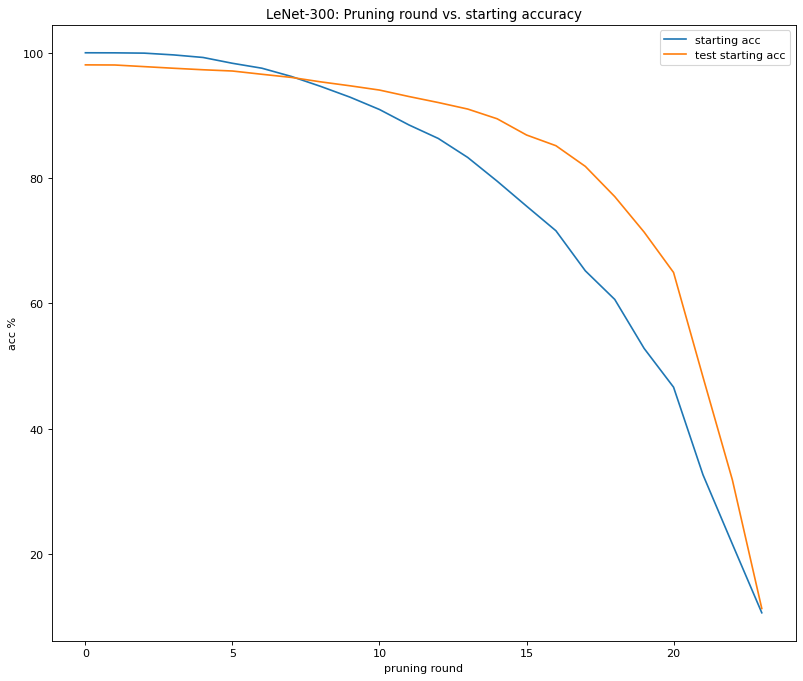

In [51]:
# Visualize best accuracy VS percentage of weights pruned-
fig = plt.figure(figsize = (12, 10), dpi =  80, facecolor = 'w', edgecolor = 'k')

plt.plot(list(plot_accuracy.keys()), list(plot_accuracy.values()), label = 'starting acc')
plt.plot(list(plot_test_accuracy.keys()), list(plot_test_accuracy.values()), label = 'test starting acc')

plt.title("LeNet-300: Pruning round vs. starting accuracy")
plt.xlabel("pruning round")
plt.ylabel("acc %")
plt.legend(loc = 'best')
plt.show()

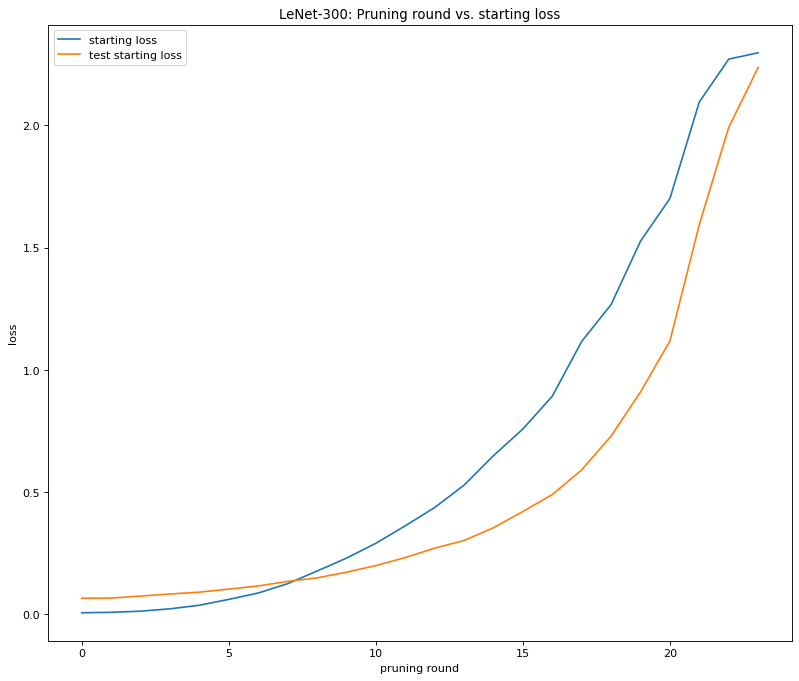

In [73]:
# Visualize best accuracy VS percentage of weights pruned-
fig = plt.figure(figsize = (12, 10), dpi =  80, facecolor = 'w', edgecolor = 'k')

plt.plot(list(plot_loss.keys()), list(plot_loss.values()), label = 'starting loss')
plt.plot(list(plot_test_loss.keys()), list(plot_test_loss.values()), label = 'test starting loss')

plt.title("LeNet-300: Pruning round vs. starting loss")
plt.xlabel("pruning round")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.show()

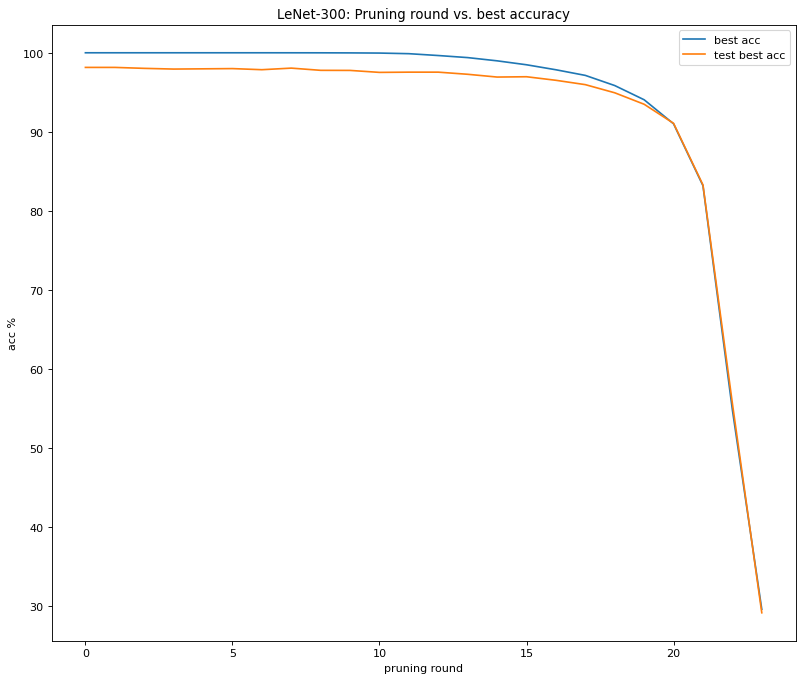

In [66]:
# Visualize best accuracy VS percentage of weights pruned-
fig = plt.figure(figsize = (12, 10), dpi =  80, facecolor = 'w', edgecolor = 'k')

plt.plot(list(plot_best_accuracy.keys()), list(plot_best_accuracy.values()), label = 'best acc')
plt.plot(list(plot_best_test_accuracy.keys()), list(plot_best_test_accuracy.values()), label = 'test best acc')

plt.title("LeNet-300: Pruning round vs. best accuracy")
plt.xlabel("pruning round")
plt.ylabel("acc %")
plt.legend(loc = 'best')
plt.show()

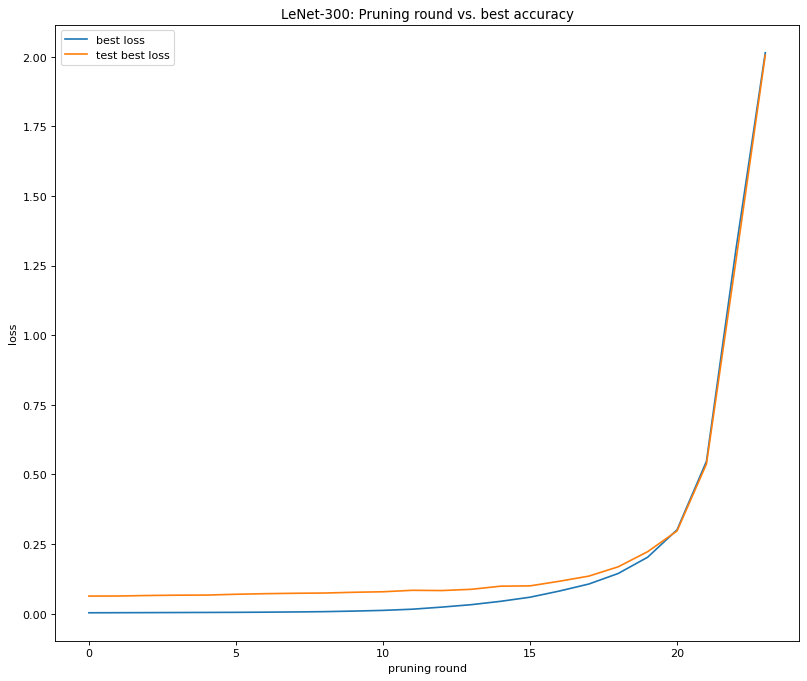

In [72]:
# Visualize best accuracy VS percentage of weights pruned-
fig = plt.figure(figsize = (12, 10), dpi =  80, facecolor = 'w', edgecolor = 'k')

plt.plot(list(plot_best_loss.keys()), list(plot_best_loss.values()), label = 'best loss')
plt.plot(list(plot_best_test_loss.keys()), list(plot_best_test_loss.values()), label = 'test best loss')

plt.title("LeNet-300: Pruning round vs. best accuracy")
plt.xlabel("pruning round")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.show()

In [10]:
# Load a pruned and trained model-
pruned_trained_model = LeNet300()
pruned_trained_model.load_state_dict(torch.load("LeNet300_best_testacc_model_97.62.pth"))
pruned_trained_model = pruned_trained_model.to(device)

In [12]:
curr_sparsity = ((orig_tot_params - count_trainable_params(pruned_trained_model)) / orig_tot_params) * 100

In [11]:
test_loss, test_acc = test_one_epoch(model = pruned_trained_model, test_loader = test_loader, test_dataset = test_dataset)

Testing: : 100%|██████████| 20/20 [00:00<00:00, 44.68batch/s, test_acc=96.5, test_loss=0.117] 


In [13]:
print(f"Sparsity = {curr_sparsity:.2f}% has test accuracy = {test_acc:.2f}%")

Sparsity = 97.62% has test accuracy = 96.52%
